# Fine-tuning Classifier LLM


In [1]:
# setup - load packages
import pandas as pd
from datasets import Dataset
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

seed = 13

cuda


In [3]:
classifier_data = pd.read_csv("/content/classifier_data_A.csv")
# converting to huggingface dataset format
data = Dataset.from_pandas(classifier_data)
# splitting into train, test and validation sets
# party data
raw_dataset = data.shuffle(seed=seed)

# 70% train, 15% test, 15% validation data
split = raw_dataset.train_test_split(test_size=0.3, seed=seed)
train_data = split["train"]
text_and_val_data = split["test"]
split = text_and_val_data.train_test_split(test_size=0.5, seed=seed)
test_data = split["train"]
val_data = split["test"]

print(f"Training samples party: {len(train_data)}")
print(f"Test samples party: {len(test_data)}")
print(f"Validation samples party: {len(val_data)}")



# data balancing??


Training samples party: 25281
Test samples party: 5418
Validation samples party: 5418


In [4]:
from transformers import AutoTokenizer
from datasets import load_dataset
from typing import Union
from typing import Mapping

In [5]:
WINDOW_LENGTH = 512
STRIDE = 256

In [6]:
# Load Tokenizer
model_name = "bert-base-german-cased"
num_labels = 6
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    model_max_length=WINDOW_LENGTH
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

In [7]:
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']
label2id = {label: i for i, label in enumerate(sorted(label_names))}
id2label = {i: label for label, i in label2id.items()}

In [25]:
def sliding_window_tokenize(batch):
    texts = batch["speech_text"]
    labels = batch["label"]  # ensure this is a flat list of ints

    tokenized = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
    )

    # Assign each overflow window the correct label
    tokenized["labels"] = [label2id[labels[i]] for i in tokenized["overflow_to_sample_mapping"]]

    return tokenized


In [61]:
from datasets import Dataset

# Beispiel: Kürzung auf 2000 Beispiele
tokenized_dataset = train_data.map(
    sliding_window_tokenize,
    batched=True,
    remove_columns=train_data.column_names
)

Map:   0%|          | 0/25281 [00:00<?, ? examples/s]

In [11]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.4 MB/s eta 0:00:00


In [62]:
print(tokenized_dataset[0]["labels"])  # sollte ein einzelner `int` sein, z. B. 3
print(type(tokenized_dataset[0]["labels"]))  # <class 'int'>

1
<class 'int'>


In [63]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import numpy as np
import evaluate


model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-german-cased",
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id
)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset.train_test_split(test_size=0.1)["train"],
    eval_dataset=tokenized_dataset.train_test_split(test_size=0.1)["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipython-input-2164122264.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.801400,0.594890,0.766977,0.767719
2,0.475200,0.302924,0.894042,0.886039
3,0.256300,0.171712,0.950701,0.949711


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=24303, training_loss=0.6086807753261517, metrics={'train_runtime': 6199.6484, 'train_samples_per_second': 31.36, 'train_steps_per_second': 3.92, 'total_flos': 5.115694103145677e+16, 'train_loss': 0.6086807753261517, 'epoch': 3.0})

In [65]:
trainer.save_model("./bert_german_speech_classifier_fulldata")

In [66]:
import torch
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Any
from datasets import Dataset

# model und tokenizer müssen schon geladen sein
model.eval()

def tokenize_sliding_windows(example: Dict[str, Any]) -> Dict[str, Any]:
    encoding = tokenizer(
        example["speech_text"],
        truncation=True,
        padding="max_length",
        max_length=WINDOW_LENGTH,
        stride=STRIDE,
        return_overflowing_tokens=True,
        return_offsets_mapping=False,
        return_tensors="pt"
    )
    return encoding

def predict_proba_for_dataset(dataset: Dataset) -> List[Dict[str, Any]]:
    results = []

    for example in tqdm(dataset):
        tokenized = tokenize_sliding_windows(example)
        input_ids = tokenized["input_ids"].to(model.device)
        attention_mask = tokenized["attention_mask"].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

        avg_probs = probs.mean(axis=0)
        results.append({
            "probs": avg_probs.tolist(),
            "label": example["label"]  # falls du wahren Wert mitgeben willst
        })

    return results


In [67]:
results = predict_proba_for_dataset(val_data)


  0%|          | 0/5418 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 5418/5418 [02:25<00:00, 37.23it/s]


In [68]:
from typing import List, Dict
import numpy as np

def add_predicted_labels(results: List[Dict], label_names: List[str]) -> List[Dict]:
    for item in results:
        probs = item["probs"]
        pred_idx = int(np.argmax(probs))
        item["prediction_label"] = label_names[pred_idx]
    return results

In [69]:
results = add_predicted_labels(results, sorted(label_names))

In [70]:
def get_metrics(true_labels, preds):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig("confusion_slidingwindow_fulldata.png")
    plt.show()


    return metrics_summary




In [71]:
results_df = pd.DataFrame(results)

Model: bert-base-german-cased
  Accuracy: 0.804171280915467
  Balanced Accuracy: 0.7888836881077682
  Precision: 0.8154652639277679
  Recall: 0.7888836881077682
  F1-score: 0.7993156386294643
  Classification Report:
              precision    recall  f1-score   support

         AfD       0.97      0.90      0.93       776
     CDU/CSU       0.81      0.85      0.83      1402
         FDP       0.78      0.67      0.72       713
       GRÜNE       0.76      0.63      0.69       712
       LINKE       0.85      0.82      0.83       581
         SPD       0.73      0.86      0.79      1234

    accuracy                           0.80      5418
   macro avg       0.82      0.79      0.80      5418
weighted avg       0.81      0.80      0.80      5418



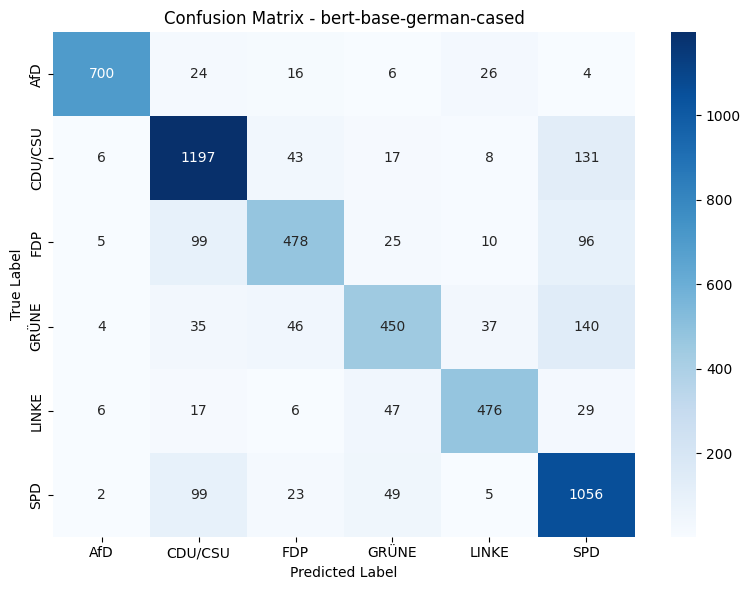

{'bert-base-german-cased': {'acc': 0.804171280915467,
  'bal_acc': np.float64(0.7888836881077682),
  'precision': 0.8154652639277679,
  'recall': 0.7888836881077682,
  'f1': 0.7993156386294643}}

<Figure size 640x480 with 0 Axes>

In [73]:
get_metrics(results_df['label'],results_df['prediction_label'])

In [75]:
results_df

,probs,label,prediction_label
0,"[0.00017410353757441044, 0.0001726595364743843...",LINKE,LINKE
1,"[0.0001470728311687708, 0.48318710923194885, 0...",CDU/CSU,CDU/CSU
2,"[0.00018254116002935916, 0.7668286561965942, 0...",CDU/CSU,CDU/CSU
3,"[0.000144667734275572, 0.3643619418144226, 0.0...",SPD,SPD
4,"[7.819286838639528e-05, 7.324050966417417e-05,...",LINKE,LINKE
...,...,...,...
5413,"[6.503691838588566e-05, 0.002560372930020094, ...",SPD,SPD
5414,"[0.0004209448234178126, 0.08983976393938065, 0...",LINKE,LINKE
5415,"[0.00042603033944033086, 0.0006034793332219124...",SPD,SPD
5416,"[0.0001148649025708437, 0.006084399297833443, ...",SPD,GRÜNE


In [74]:
results_df.to_csv("results_slidingwindow_fulldata.csv")

# ____
# Ella

In [ ]:
def predicting_probs(model, speech):
    # Put model in eval mode
    model.eval()

    #  Tokenize input speeches
    tokens = tokenizer(speech, return_tensors="pt", truncation=False)["input_ids"][0]

    chunks = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]

    all_probs = []
    i = 0
    for chunk in chunks:
        input_dict = {"input_ids": chunk.unsqueeze(0)}  # Add batch dimension
        # Add attention mask
        input_dict["attention_mask"] = (chunk != tokenizer.pad_token_id).unsqueeze(0)


        # Run model to predict baseline
        with torch.no_grad():
            outputs = model(**input_dict)
            logits = outputs.logits
            probabilities = F.softmax(logits, dim=1)
            all_probs.append(probabilities)
            i+=1
    # averaging probabilites over all probabilities in speech parts
    avg_probs = torch.mean(torch.cat(all_probs, dim=0), dim=0)
    print(i , avg_probs)

    return avg_probs


def predicting_probs_to_preds(model, speech):
    # get probabilites
    probabilities = predicting_probs(model, speech)
    # convert to predictions
    predictions_nr = torch.argmax(probabilities).item()
    predictions = label_names[predictions_nr]
    return predictions, probabilities



In [ ]:
# collect evaluation data
def evaluate_model(model, data):
    prediction_list = []
    probability_list = []
    true_label_list = []

    for i, row in enumerate(data):
        speech = row["speech_text"]
        pred, probs = predicting_probs_to_preds(model, speech)
        true_label = row["label"]
        prediction_list.append(pred)
        probability_list.append(probs)
        true_label_list.append(true_label)

        if (i+1) % 100 == 0:
            print(f"Processed samples {i+1} of {len(data)} samples.")

    return prediction_list, probability_list, true_label_list


# define function to display eval metrics
def get_metrics(true_labels, preds):
    metrics_summary = {}

    acc = accuracy_score(true_labels, preds)
    bal_acc = balanced_accuracy_score(true_labels, preds)

    precision = precision_score(true_labels, preds, average='macro', zero_division=0)
    recall = recall_score(true_labels, preds, average='macro', zero_division=0)
    f1 = f1_score(true_labels, preds, average='macro', zero_division=0)

    label_order = sorted(set(true_labels).union(set(preds)))
    report = classification_report(true_labels, preds, labels=label_order, zero_division=0)
    metrics_summary[model_name] = {
        'acc': acc,
        'bal_acc': bal_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    # print metrics
    print(f"Model: {model_name}")
    print(f"  Accuracy: {acc}")
    print(f"  Balanced Accuracy: {bal_acc}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1-score: {f1}")
    print(f"  Classification Report:\n{report}")


    # Confusion Matrix
    label_order = sorted(set(true_labels).union(set(preds)))
    cm = confusion_matrix(true_labels, preds, labels=label_order)
    cm_df = pd.DataFrame(cm, index=label_order, columns=label_order)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()


    return metrics_summary







2 tensor([0.1638, 0.1763, 0.1356, 0.1829, 0.1976, 0.1439])
2 tensor([0.1672, 0.1794, 0.1407, 0.1917, 0.1851, 0.1359])
4 tensor([0.1416, 0.1736, 0.1349, 0.1676, 0.2092, 0.1731])
1 tensor([0.1766, 0.1864, 0.1316, 0.1716, 0.1737, 0.1600])
2 tensor([0.1714, 0.1774, 0.1366, 0.1686, 0.1937, 0.1523])
3 tensor([0.1592, 0.1944, 0.1489, 0.1750, 0.1919, 0.1307])
2 tensor([0.1515, 0.1829, 0.1564, 0.1505, 0.2032, 0.1556])
2 tensor([0.1481, 0.1805, 0.1386, 0.1783, 0.2015, 0.1530])
2 tensor([0.1567, 0.1791, 0.1503, 0.1910, 0.1812, 0.1417])
2 tensor([0.1830, 0.1787, 0.1432, 0.1813, 0.1825, 0.1314])
2 tensor([0.1488, 0.1712, 0.1350, 0.1757, 0.2253, 0.1440])
1 tensor([0.1555, 0.1856, 0.1391, 0.1738, 0.2094, 0.1366])
3 tensor([0.1610, 0.1727, 0.1535, 0.1758, 0.1915, 0.1454])
2 tensor([0.1663, 0.1954, 0.1321, 0.1807, 0.1814, 0.1442])
2 tensor([0.1624, 0.1677, 0.1351, 0.1836, 0.2178, 0.1335])
3 tensor([0.1588, 0.1871, 0.1419, 0.1819, 0.1936, 0.1367])
2 tensor([0.1479, 0.1596, 0.1451, 0.1900, 0.2028, 0.1545

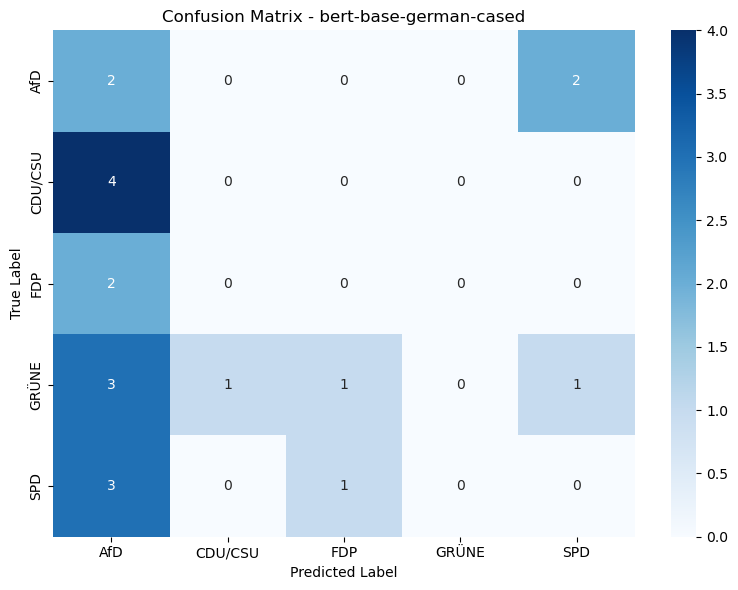

{'bert-base-german-cased': {'acc': 0.1,
  'bal_acc': 0.1,
  'precision': 0.02857142857142857,
  'recall': 0.1,
  'f1': 0.044444444444444446}}

In [ ]:
# Get zero-shot example performance
prediction_list, probability_list, true_label_list = evaluate_model(model, val_data)
print(probability_list)
get_metrics(true_label_list, prediction_list)

In [ ]:
classifier_data = classifier_data[:2000]

In [ ]:
classifier_data.head()

,speech_text,label
0,Herr Präsident! Kolleginnen und Kollegen! Die ...,1
1,Sehr geehrter Herr Präsident! Liebe Kolleginne...,5
2,Herr Präsident! Liebe Kolleginnen und Kollegen...,1
3,Herr Präsident! Liebe Kolleginnen und Kollegen...,3
4,Liebe Kolleginnen und Kollegen! Es ist vorhin ...,2


In [ ]:
party_to_id = {party: i for i, party in enumerate(sorted(classifier_data['label'].unique()))}

In [ ]:
party_to_id

{'AfD': 0, 'CDU/CSU': 1, 'FDP': 2, 'GRÜNE': 3, 'LINKE': 4, 'SPD': 5}

In [ ]:
classifier_data['label'] = classifier_data['label'].map(party_to_id)

C:\Users\Estelle\AppData\Local\Temp\ipykernel_27120\3929469336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classifier_data['label'] = classifier_data['label'].map(party_to_id)


In [ ]:
classifier_data.head()

,speech_text,label
0,Herr Präsident! Kolleginnen und Kollegen! Die ...,1
1,Sehr geehrter Herr Präsident! Liebe Kolleginne...,5
2,Herr Präsident! Liebe Kolleginnen und Kollegen...,1
3,Herr Präsident! Liebe Kolleginnen und Kollegen...,3
4,Liebe Kolleginnen und Kollegen! Es ist vorhin ...,2


In [ ]:
# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(classifier_data)

# Tokenize
def tokenize(batch):
    return tokenizer(batch['speech_text'], truncation=True, padding='max_length', max_length=max_length)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")  # required name
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

dataset = dataset.train_test_split(test_size=0.3)  # 90% train, 10% val
train_dataset = dataset['train']
val_and_test_dataset = dataset['test']
val_and_test_dataset = val_and_test_dataset.train_test_split(test_size=0.5)  # 90% train, 10% val
val_dataset = val_and_test_dataset['train']
test_dataset = val_and_test_dataset['test']

Map:   0%|          | 0/36117 [00:00<?, ? examples/s]

In [ ]:
# fine-tunen
training_args = TrainingArguments(
    output_dir="./bert-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)


import evaluate
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# train
trainer.train()


/tmp/ipython-input-1549188525.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.949800,0.873547,0.659468
2,0.672300,0.771991,0.706165
3,0.396900,0.857263,0.717977


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=9483, training_loss=0.7657745885884197, metrics={'train_runtime': 1706.159, 'train_samples_per_second': 44.452, 'train_steps_per_second': 5.558, 'total_flos': 1.9955848447973376e+16, 'train_loss': 0.7657745885884197, 'epoch': 3.0})

In [ ]:
# validaten

trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.8572631478309631,
 'eval_accuracy': 0.7179771133259505,
 'eval_runtime': 35.9672,
 'eval_samples_per_second': 150.637,
 'eval_steps_per_second': 18.851,
 'epoch': 3.0}

In [ ]:
# compare 2 versions (erinnern!)



In [ ]:
# outcomes test data conf matrix, accuracy



In [ ]:
# save model for futher tests on LLM generated speeches



__________________________________________________________________________________

Old to save
__________________________________________________________________________________

In [ ]:
# Load Model
model_name = "bert-base-german-cased"
num_labels = 6
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels= num_labels) # classification head with one linear layer and num_label outputs is added on top of model here.

print(f"Model parameters: {model.num_parameters():,}")

# Put model in eval mode
model.eval()

# Define possible label names
label_names = ['CDU/CSU', 'SPD', 'GRÜNE', 'FDP', 'AfD', 'LINKE']

#  Tokenize input speeches
inputs = tokenizer(val_data_subset["speech_text"], return_tensors="pt", padding=True, truncation=False) # padding pads all speeches to the same length and truncation cuts all speeches to 512 tokens

# Run model to predict basline
with torch.no_grad(): # turns of gradient tracking, since we are not training
    outputs = model(**inputs) # passes tokenized inputs into model, returns output dict
    logits = outputs.logits # output dict contains logits
    probabilities = F.softmax(logits, dim=1) # logits to probabilities
    predictions = torch.argmax(probabilities, dim=1) # probabilities to predictions (i.e. highest probability)

# 7. Print prediction examples
for i, pred in enumerate(predictions):
    print(f"Speech {i+1}: predicted party = {label_names[pred]}")
print(logits)

for i, probs in enumerate(probabilities):
    print(f"Speech {i+1} prediction:")
    for label, prob in zip(label_names, probs):
        print(f"  {label:7s}: {prob.item():.2%}")